<a href="https://colab.research.google.com/github/homembit/AI_Tutorials/blob/main/MNIST_Youtube.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **MNIST - O Hello World de AI :)**

Uma boa visualização do que vamos fazer, interativa pode ser encontrada nesse site
http://scs.ryerson.ca/~aharley/vis/conv/

A topologia básica da rede que vamos montar é a [LeNet](https://en.wikipedia.org/wiki/LeNet), e pode ser simplificada assim:

![alt text](https://upload.wikimedia.org/wikipedia/commons/6/63/Typical_cnn.png)


# Montar nossa CNN e realizar o treinamento

O Keras pode importar muitas topologias prontas, mas vamos construir essa na mão.

Iniciamos importando um modelo de rede neural [sequencial](https://keras.io/models/sequential/).


In [1]:
from tensorflow.keras.models import Sequential

Documentação das camadas principais do Keras https://keras.io/layers/core/

> **Dense**: Vamos usar uma camada densa como camada de classificação
> 
> **Flatten**: Camada para transformar matriz em vetor
> 
> **Dropout**: Camada para descartar aleatoriamente uma parte dos dados

In [2]:
from tensorflow.keras.layers import Dense, Flatten, Dropout

Documentação das camadas de convolução https://keras.io/layers/convolutional/
> **Conv2D**: Camada de convolução de imagens em 2D (nossas imagens com os digitos de entrada, vindo do nosso dataset)


In [3]:
from tensorflow.keras.layers import Conv2D

Documentação da camada de Pooling: https://keras.io/layers/pooling/
> **MaxPooling2D**: Camada para reduzir as matrizes

In [4]:
from tensorflow.keras.layers import MaxPooling2D

Funções de utilitários do Keras https://keras.io/utils/

In [5]:
from tensorflow.keras import utils

Dataset do MNIST https://keras.io/datasets/
Este Dataset tem 60.000 imagens de 28x28 pixels de numeros de 0-9 para treinamento com mais 10.000 imagens para testes 

In [6]:
from tensorflow.keras.datasets import mnist

Otimizador Adam para a descida do gradiente

In [7]:
from tensorflow.keras.optimizers import Adam

Call backs do Keras para a otimização do treinamento
>**ModelCheckpoint**: Grava cada modelo treinado que a obedeça um critério específico
>
>**EarlyStopping**: Interrompe o treinamento quando um critério é atendido
>
>**ReduceLROnPlateau**: Reduz o Learning Rate quando está próximo de um ponto de mínimo
>
>**TensorBoard**: Gera dados para análise e acompanhamento do treinamento no TensoBoard

In [8]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard

Carrega o DataSet do MNIST data em dois conjuntos: Treinamento (60K imagens) e Testes (10k imagens)

In [9]:
(train_dataset, train_classes),(test_dataset, test_classes) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


Ajusta os datasets para o TensorFlow, reduzindo os canais de imagens de 3 para 1 

In [10]:
train_dataset = train_dataset.reshape(train_dataset.shape[0], 28, 28, 1)
test_dataset = test_dataset.reshape(test_dataset.shape[0], 28, 28, 1)

Converte os dados de int8 para float32

In [11]:
train_dataset = train_dataset.astype('float32')
test_dataset = test_dataset.astype('float32')

Normaliza os dados para acelerar o processamento, reduzindo o tamanho dos números

In [12]:
train_dataset = train_dataset / 255
test_dataset = test_dataset / 255

Converte as classes de dados de numérica para categorias

In [13]:
train_classes = utils.to_categorical(train_classes, 10)
test_classes = utils.to_categorical(test_classes, 10)

Cria a Rede Neural Convolucional (Convolutional Neural Network)

In [14]:
cnn = Sequential()

Adiciona a primeira camada convolucional com 32 filtros e uma janela de convolução de 3x3, com a matriz de entrada com imagens de 28 x 28 pixels (1 canal de cores) e usando ativação ReLu ([Rectified Linear Unit](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)))




In [15]:
cnn.add(Conv2D(32, (3,3), input_shape = (28, 28, 1), activation = 'relu'))

Reduz o tamanho das matrizes de convolução

In [16]:
cnn.add(MaxPooling2D())

Descarta aleatoriamente 25% das imagens

**NOTA:** Altere esse percentual e observe a diferença na acurácia :)

In [17]:
cnn.add(Dropout(0.25))

Transforma a matriz de saída em um vetor para ser processado pela rede neural


In [18]:
cnn.add(Flatten())

Primeira camada da rede neural, uma camada oculta com 128 neurônios e usando ReLu como ativação 

In [19]:
cnn.add(Dense(units = 128, activation = 'relu'))

Descarta aleatoriamente 50% dos resultados

**NOTA:** Altere esse percentual e observe a diferença na acurácia :)


In [20]:
cnn.add(Dropout(0.5))

**NOTA:** Como exercício aqui, incluir mais camadas ocultas e observar os resultados no tempo de treinamento vs acurácia.

Camada de saída com 10 neurônios (um para cada camanda) usando Softmax como função de ativação, dada a natureza do problema matemático

In [21]:
cnn.add(Dense(units = 10, activation = 'softmax'))

Compilar a CNN com:
>- [Categorical crossentropy](https://keras.io/api/losses/probabilistic_losses/#categoricalcrossentropy-class) como função de perda
>- Otimizador [Adam](https://keras.io/api/optimizers/adam/) 
>- Acurácia como métrica de avaliação (Loss pode ser usado também.. pesquise sobre [Overfitting](https://en.wikipedia.org/wiki/Overfitting) para entender)


In [22]:
adam = Adam(lr=0.001)
cnn.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])

Setup dos callbacks:

Nome do arquivo para o o [ModelCheckPoint](https://keras.io/api/callbacks/model_checkpoint/), um callback que grava os pesos da rede a cada ciclo de treinamento, baseado em critérios.

In [23]:
top_layers_file_path="MNIST_Model.iv3.hdf5"

Monitorar a loss function e salvar cada vez que ela for menor que a anterior
otimiza o treinamento para encontrar o ponto de mínima.

In [24]:
checkpoint = ModelCheckpoint(top_layers_file_path, monitor='loss', verbose=1, save_best_only=True, mode='min')

O [EarlyStopping](https://keras.io/api/callbacks/early_stopping/) informa quantas vezes ele deve tentar reduzir o valor da loss funcion 
antes de interromper o treinamento. Interessante notar o nome do parâmetro do número de vezes: patience :)

**Dica**: Aqui falamos pro Keras  que monitore a loss function, pelo mínimo até que ele não diminua em 5 vezes... como gravamos o checkpoint em cada redução no callback anterior... teremos a melhor versão da rede gravada em disco

In [25]:
early = EarlyStopping(monitor="loss", mode="min", patience=30)

Gera os dados para a análise do treinamento no [TensorBoard](https://keras.io/api/callbacks/tensorboard/)

In [26]:
tb = TensorBoard(log_dir='./logs', batch_size=128, write_graph=True, update_freq='batch')

Pedimos pro Keras reduzir o Learning Rate quando estiver perto de um ponto de
mínima... it's magic :) ... não... é matemática mesmo :P

In [27]:
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=10, min_lr=0.0001)

Executa o treinamento da rede em 50 épocas, validando o resultado com o dataset
de treinamento em cada época...

**Dica:** Aumente o número de épocas para um número maior, e os dois callbacks que ajustamos anteriormente devem salvar seu cartão de crédito  


In [28]:
cnn.fit(train_dataset, train_classes, batch_size = 128, epochs = 300,
        validation_data = (test_dataset, test_classes),
        callbacks=[checkpoint, early, reduce_lr, tb])

Epoch 1/300
  1/469 [..............................] - ETA: 0s - loss: 2.3270 - accuracy: 0.0781WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
469/469 [==============================] - ETA: 0s - loss: 0.3203 - accuracy: 0.9053
Epoch 00001: loss improved from inf to 0.32029, saving model to MNIST_Model.iv3.hdf5
469/469 [==============================] - 3s 6ms/step - loss: 0.3203 - accuracy: 0.9053 - val_loss: 0.0881 - val_accuracy: 0.9730
Epoch 2/300
465/469 [============================>.] - ETA: 0s - loss: 0.1250 - accuracy: 0.9633
Epoch 00002: loss improved from 0.32029 to 0.12461, saving model to MNIST_Model.iv3.hdf5
469/469 [==============================] - 3s 5ms/step - loss: 0.1246 - accuracy: 0.9633 - val_loss: 0.0633 - val_accuracy: 0.9786
Epoch 3/

Com a rede treinada, vamos usar o dataset de testes para extrair os dados para análise quantitativa da performance da rede

In [29]:
result = cnn.evaluate(test_dataset, test_classes)
print ('Accuracy = ' + str(result[1] * 100) + "%")

313/313 [==============================] - 1s 2ms/step - loss: 0.0582 - accuracy: 0.9909
Accuracy = 99.08999800682068%


# Analise da qualidade do modelo

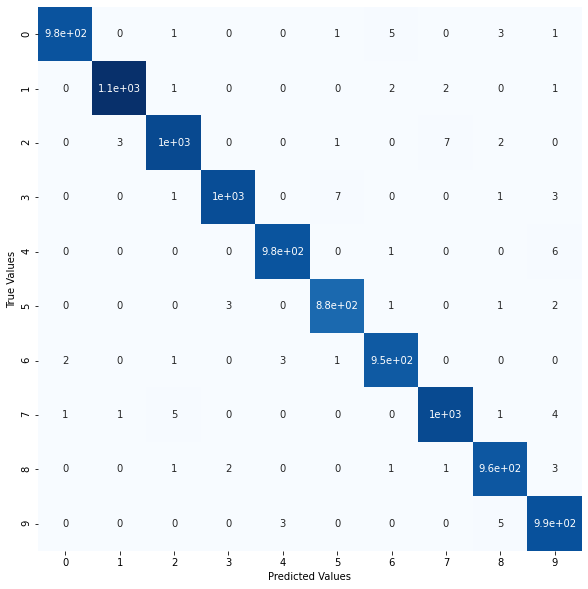

Accuracy 99.09%
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       980
           1       0.99      1.00      1.00      1135
           2       0.99      0.99      0.99      1032
           3       0.99      1.00      0.99      1010
           4       0.99      0.99      0.99       982
           5       0.99      0.99      0.99       892
           6       0.99      0.99      0.99       958
           7       0.99      0.99      0.99      1028
           8       0.99      0.99      0.99       974
           9       0.99      0.98      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



In [30]:
# Confusion Matrix stuff
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

fig = plt.figure(figsize=(10, 10)) # Set Figure

y_pred = cnn.predict(test_dataset)

Y_pred = np.argmax(y_pred, 1) # Decode Predicted labels
Y_test = np.argmax(test_classes, 1) # Decode labels

mat = confusion_matrix(Y_test, Y_pred) # Confusion matrix

# Plot Confusion matrix
sns.heatmap(mat.T, square=True, annot=True, cbar=False, cmap=plt.cm.Blues)
plt.xlabel('Predicted Values')
plt.ylabel('True Values');
plt.show();

print("Accuracy {0:.2f}%".format(100*accuracy_score(Y_pred, Y_test)))

print(classification_report(Y_test, Y_pred))